#Mounting the Drive

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# import libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

from matplotlib import pyplot as plt
import tensorflow as tf
tf.random.seed= 42

from keras.layers import LeakyReLU
import cv2
from tqdm import tqdm
import random
import math
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
np.random.seed(42)

# Data Preprocessing

In [ ]:
dataframe = pd.read_csv('/content/drive/MyDrive/TEZDA_TASK/Dataset/age_gender.csv')

In [ ]:
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

# Create a custom data generator class that inherits from tf.keras.utils.Sequence
class DataGen(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size=32, input_size=(48, 48, 3), shuffle=True, data_augmentation=False):
        self.df = df
        self.batch_size = batch_size
        self.input_size = input_size
        self.data_augmentation = data_augmentation

        # Initialize an image data generator for data augmentation
        self.imageGenerator = ImageDataGenerator(
            horizontal_flip=True,
            fill_mode='nearest',
            zoom_range=(1, 1.1),
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10
        )

        # Initialize an image data generator for data augmentation
        self.images, self.age_labels, self.ethnicity_labels, self.gender_labels = self._load_data()
        # Randomly permute the data
        self.images, self.age_labels, self.ethnicity_labels, self.gender_labels = self._random_permutation(
            [self.images, self.age_labels, self.ethnicity_labels, self.gender_labels])
        # Get the number of samples in the dataset
        self.n = len(self.df)

    # Load and preprocess data from the DataFrame
    def _load_data(self):
        images = []
        age_labels = []
        ethnicity_labels = []
        gender_labels = []

        # Loop through the DataFrame rows and extract image and labels
        for _, row in tqdm(self.df.iterrows()):
            image = np.fromstring(row['pixels'], sep=' ', dtype=np.uint8).reshape((48, 48))
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
            images.append(image)
            age_labels.append(row['age'])
            ethnicity_labels.append(row['ethnicity'])
            gender_labels.append(row['gender'])

        # Convert lists to NumPy arrays for compatibility with TensorFlow
        images = np.array(images)
        age_labels = np.array(age_labels, dtype=np.float32)
        ethnicity_labels = to_categorical(ethnicity_labels, num_classes=5).astype(np.float32)
        gender_labels = np.array(gender_labels, dtype=np.float32)

        return images, age_labels, ethnicity_labels, gender_labels

    # Randomly permute the data
    @staticmethod
    def _random_permutation(data_list):
        p = np.random.permutation(len(data_list[0]))
        return [data[p] for data in data_list]

    # Get a batch of data at a specific index
    def __getitem__(self, index):
        images = [self.images[index * self.batch_size + i] for i in range(self.batch_size)]

        if self.data_augmentation:
            images = [self.imageGenerator.random_transform(image) for image in images]

        s = slice(self.batch_size * index, (index + 1) * self.batch_size)
        return np.array(images), (self.age_labels[s], self.ethnicity_labels[s], self.gender_labels[s])

   # Get the number of batches
    def __len__(self):
        return self.n // self.batch_size

    # Called at the end of each epoch to shuffle the data
    def on_epoch_end(self):
        self.images, self.age_labels, self.ethnicity_labels, self.gender_labels = self._random_permutation(
            [self.images, self.age_labels, self.ethnicity_labels, self.gender_labels])




# Splitting Data into Training and Validation

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
train_data, val_data = train_test_split(dataframe, test_size=0.2, random_state=42)

# Create DataGen instances for the training and validation datasets
train_dataset = DataGen(train_data, data_augmentation=True)
val_dataset = DataGen(val_data)


18964it [00:02, 8351.45it/s]
4741it [00:00, 8716.81it/s]


# Define Model Architecture (ResNet50)

In [ ]:
import tensorflow as tf
from keras.layers import Input, Dense, BatchNormalization, Dropout, Flatten, LeakyReLU
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras import Model

input_shape = (48, 48, 3)
i = Input(input_shape, dtype=tf.uint8)
x = tf.cast(i, tf.float32)

# Use ResNet50 preprocessing
x = preprocess_input(x)

# Import ResNet50 from Keras
backbone = ResNet50(
    include_top=False, weights='imagenet', input_tensor=x
)
output_layer = backbone.output  # Use the output of ResNet50 as the backbone's output

# Age branch
age_head = Flatten()(output_layer)
age_head = Dense(512, activation=LeakyReLU(alpha=0.3))(age_head)
age_head = BatchNormalization()(age_head)
age_head = Dropout(0.3)(age_head)
output_age = Dense(1, activation='linear', name='age_output')(age_head)

# Ethnicity branch
ethnicity_head = Flatten()(output_layer)
ethnicity_head = Dense(512, activation=LeakyReLU(alpha=0.3))(ethnicity_head)
ethnicity_head = BatchNormalization()(ethnicity_head)
ethnicity_head = Dropout(0.3)(ethnicity_head)
output_ethnicity = Dense(5, activation='softmax', name='ethnicity_output')(ethnicity_head)

# Gender branch
gender_head = Flatten()(output_layer)
gender_head = Dense(512, activation=LeakyReLU(alpha=0.3))(gender_head)
gender_head = BatchNormalization()(gender_head)
gender_head = Dropout(0.3)(gender_head)
output_gender = Dense(1, activation='sigmoid', name='gender_output')(gender_head)

# Define the model with the same input but multiple outputs
model = Model(inputs=i, outputs=[output_age, output_ethnicity, output_gender])

from keras.optimizers import Adam
model.compile(Adam(learning_rate=1e-4), loss = ['mse', 'categorical_crossentropy', 'binary_crossentropy'], loss_weights = [0.6, 0.5, 0.5],
              metrics = {'age_output': 'mean_absolute_error', 'ethnicity_output': 'accuracy', 'gender_output': 'accuracy'})


from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Reduce the learning rate when validation loss plateaus
plateau = ReduceLROnPlateau(
      monitor='val_loss', factor=0.3, patience=5, verbose = 1
)

# Introducing early_stopping to help avoid overfitting
Early_st = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                                      patience=25)  # Early stopping (stops training when validation doesn't improve for {patience} epochs)

# Saves the best version of the model to disk (as measured on the validation data set)
save_best_model = ModelCheckpoint('/content/drive/MyDrive/TEZDA_TASK/my_model_R50.h5', monitor='val_loss', save_best_only=True,
                                    mode='min', save_weights_only=True)

model.summary()


94765736/94765736 [==============================] - 4s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 48, 48, 3)]          0         []                            
                                                                                                  
 tf.cast (TFOpLambda)        (None, 48, 48, 3)            0         ['input_1[0][0]']             
                                                                                                  
 tf.__operators__.getitem (  (None, 48, 48, 3)            0         ['tf.cast[0][0]']             
 SlicingOpLambda)                                                                                 
                                                                                                  
 tf.nn.bias_add (TFOpLambda  

# Train model with 60 epochs and 32 batch size

In [ ]:
epochs =60
batch_size= 32
history = model.fit(train_dataset,
            epochs=epochs,
            batch_size =batch_size,
            validation_data=val_dataset,
            callbacks = [save_best_model, plateau, Early_st])


# Save the model with the specified file name
#model.save('/content/drive/MyDrive/TEZDA_TASK/multi_taskRN50.keras')

Epoch 1/60
592/592 [==============================] - 61s 47ms/step - loss: 729.2209 - age_output_loss: 1213.4244 - ethnicity_output_loss: 1.6333 - gender_output_loss: 0.6997 - age_output_mean_absolute_error: 32.4577 - ethnicity_output_accuracy: 0.4617 - gender_output_accuracy: 0.6995 - val_loss: 421.9631 - val_age_output_loss: 701.5525 - val_ethnicity_output_loss: 1.3987 - val_gender_output_loss: 0.6649 - val_age_output_mean_absolute_error: 23.7271 - val_ethnicity_output_accuracy: 0.5745 - val_gender_output_accuracy: 0.7352 - lr: 1.0000e-04
Epoch 2/60
592/592 [==============================] - 26s 43ms/step - loss: 587.8378 - age_output_loss: 978.2211 - ethnicity_output_loss: 1.2599 - gender_output_loss: 0.5513 - age_output_mean_absolute_error: 29.4189 - ethnicity_output_accuracy: 0.5524 - gender_output_accuracy: 0.7483 - val_loss: 472.4826 - val_age_output_loss: 786.1914 - val_ethnicity_output_loss: 1.0894 - val_gender_output_loss: 0.4458 - val_age_output_mean_absolute_error: 26.2745

# Load the Saved Model for evaluation

In [ ]:
# Load the model back

from keras.models import load_model
model_path ='/content/drive/MyDrive/TEZDA_TASK/my_model_R50.h5'
model.load_weights(model_path)


# Plot Training and Validation Loss

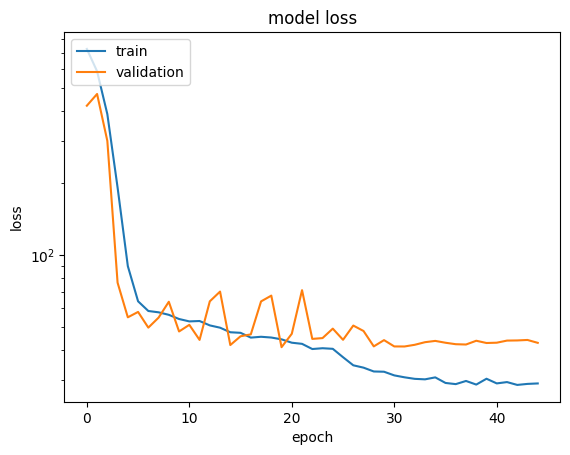

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.yscale('log')
plt.savefig('model_loss_plot.png')
plt.show()

# Evaluate all the three heads base on their Metrics

In [ ]:

# Evaluate the model on the validation dataset
evaluation_results = model.evaluate(val_dataset)

# The 'evaluate' method returns a list of evaluation metrics.
# You can retrieve the metric names and their corresponding values as follows:
metric_names = model.metrics_names
metric_values = evaluation_results

# Print the evaluation metrics
for name, value in zip(metric_names, metric_values):
    print(f'{name}: {value}')


148/148 [==============================] - 11s 10ms/step - loss: 41.2419 - age_output_loss: 67.7607 - ethnicity_output_loss: 0.8562 - gender_output_loss: 0.3147 - age_output_mean_absolute_error: 5.8133 - ethnicity_output_accuracy: 0.6864 - gender_output_accuracy: 0.8541
loss: 41.24186325073242
age_output_loss: 67.7607192993164
ethnicity_output_loss: 0.8561702370643616
gender_output_loss: 0.31467947363853455
age_output_mean_absolute_error: 5.813261985778809
ethnicity_output_accuracy: 0.6864442825317383
gender_output_accuracy: 0.8540962934494019


# Evaluate Age Predictions based on Criterion

In [ ]:
from sklearn.metrics import mean_absolute_error

#lets assume the ethnicity values 0-4 are as follow
names_ethnicity = ['Eth_0', 'Eth_1', 'Eth_2', 'Eth_3', 'Eth_4']

#Lets assume the values 0, 1 are as follow 0:male, 1:female
name_genders = ['male', 'female']

#extract images and labels from val_dataset
images, labels = val_dataset[10]



In [ ]:
from sklearn.metrics import mean_absolute_error

#predicts on val images extracted above
predictions = model.predict(images)

# Assuming you have the predictions, true labels, and names_ethnicity and name_genders defined
age_predictions = predictions[0][:, 0]  # Extract age predictions from predictions
true_ages = labels[0][:]  # Extract true ages from labels

# Calculate Age MAE (Mean Absolute Error)
age_mae = mean_absolute_error(true_ages, age_predictions)

# Calculate Age Accuracy within a ±5 year margin
age_accuracy = (abs(true_ages - age_predictions) <= 10).mean()

print(f"Age MAE: {age_mae}")
print(f"Age Accuracy (within ±10 years): {age_accuracy * 100:.2f}%")


1/1 [==============================] - 1s 1s/step
Age MAE: 4.269084930419922
Age Accuracy (within ±10 years): 96.88%


# Evaluate Age predictions based on Age Groups

In [ ]:
import numpy as np

# Define age groups for actual ages and predicted ages
age_groups = {
    "child": (0, 17),
    "Young": (18, 45),
    "adult": (46, 70),
    "senior_adult": (71, 90),
    "old_man": (91, 120)
}

# Function to assign age group based on age
def assign_age_group(age, age_groups):
    for group, (min_age, max_age) in age_groups.items():
        if min_age <= age <= max_age:
            return group
    return None

# Assuming you have the predictions and true labels
age_predictions = predictions[0][:, 0]  # Extract age predictions from predictions
true_ages = labels[0][:]  # Extract true ages from labels

# Assign age groups for actual and predicted ages
true_age_groups = [assign_age_group(age, age_groups) for age in true_ages]
predicted_age_groups = [assign_age_group(age, age_groups) for age in age_predictions]

# Calculate accuracy between actual and predicted age groups
age_group_accuracy = np.mean(np.array(true_age_groups) == np.array(predicted_age_groups))

print(f"Age Group Accuracy: {age_group_accuracy * 100:.2f}%")


Age Group Accuracy: 93.75%


#Visualize Model Predictions

<ipython-input-11-6eb859e59e85>:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predicted_age = predictions[0][index].astype(np.int)[0]


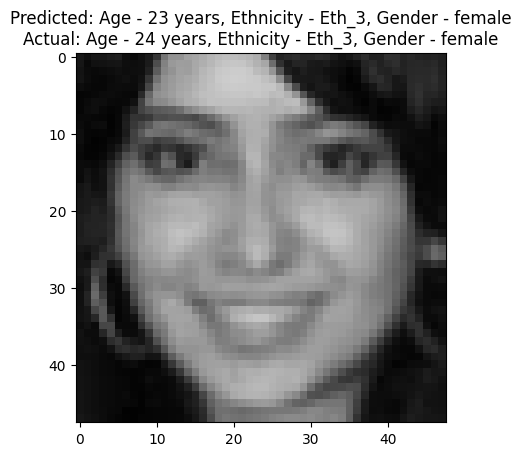

In [ ]:
index =22

# Calculate gender predictions based on the model's output
gender_predictions = tf.where(predictions[2] > 0.5, 1, 0)

# Extract predicted age and convert it to an integer
predicted_age = predictions[0][index].astype(np.int)[0]

# Determine the predicted ethnicity based on the model's output
predicted_ethnicity = names_ethnicity[predictions[1][index].argmax()]

# Determine the predicted gender based on the gender predictions
predicted_gender = name_genders[gender_predictions[index][0]]

# Extract the actual age from the ground truth labels and convert it to an integer
actual_age = int(labels[0][index])

# Determine the actual ethnicity based on the ground truth labels
actual_ethnicity = names_ethnicity[labels[1][index].argmax()]

# Determine the actual gender based on the ground truth labels
actual_gender = name_genders[int(labels[2][index])]

title_text = f'Predicted: Age - {predicted_age} years, Ethnicity - {predicted_ethnicity}, Gender - {predicted_gender}\n'
title_text += f'Actual: Age - {actual_age} years, Ethnicity - {actual_ethnicity}, Gender - {actual_gender}'

plt.title(title_text)
plt.imshow(images[index])
plt.show()
